# RNN Rap Generator

### Author: Wezley Sherman

### Email: wezleysherman@yahoo.com

### Medium: https://medium.com/@dawezdog

### GitHub: https://github.com/wezleysherman/



The purpose of this project is to compare four different models for ghost writing. Each model uses a different type of architecture to generate rap lyrics. The architectures consist of: SimpleRNN, GRU, LSTM, and CNN + LSTM 
<br>
<br>

---
<br>

Copyright 2020 Wezley Sherman

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
<br>
<br>

---

<br>

## References:


 * ["Evaluating Creative Language Generation: The Case of Rap Lyric Ghostwriting"](https://arxiv.org/pdf/1612.03205.pdf) by Peter Potash, Alexey Romanov, Anna Rumshisky

 * ["Song Lyrics" Dataset](https://www.kaggle.com/paultimothymooney/poetry
) by Paul Mooney

* [Recurrent Neural Networks](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/ch04.html) By O'Reilly

* [A C-LSTM Neural Network for Text Classification](https://arxiv.org/pdf/1511.08630.pdf) by Chunting Zhou, Chonglin Sun, Zhiyuan Liu, Francis C.M. Lau

<br>
<br>

---

<br>


The first thing I want to do is check out which GPU Colab Pro assigned me. 

In [ ]:
!nvidia-smi

Sun Jul 26 00:04:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

For this project I'm using a few libraries that aren't already included in Google Colab.

These include:

* [Pronouncing](https://pypi.org/project/pronouncing/) - Used for calculating rhyme index
* [Kaggle](https://pypi.org/project/kaggle/) - Used for obtaining the dataset of artist lyrics
* [Markovify](https://pypi.org/project/markovify/) - Used to create the base markov model for generating base lyrics
* [Textstat](https://pypi.org/project/textstat/) - Used to calculate the readability score for a bar

Then allow the user to upload their Kaggle API Token. This'll be used for fetching the dataset of

In [ ]:
!pip3 install pronouncing
!pip3 install kaggle
!pip3 install markovify
!pip3 install textstat
!pip3 install better-profanity

from google.colab import files
files.upload()

     |████████████████████████████████| 942kB 6.9MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=9bdb69586f36cb742d579af5dc088ebc4601c6293c2155ab65135ac0c9d0ea07
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing
     |████████████████████████████████| 245kB 6.9MB/s 
  Created wheel for markovify: filename=markovify-0.8.2-cp36-none-any.whl size=18261 sha256=6f2187f9b82f62d42a68cab569c091f4eeafdb2dc4808d68c8780a5c77d6dcfb
  Stored in directory: /root/.cache/pip/wheels/f4/3f/cc/c2750c71a820928e12f9609ff3a99d7b2c0d93eb61b7170189
Successfully built markovify
     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 3.0MB 18.7MB/s 
     |████████████████████████████████| 51kB 2.5MB/s 


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"twoface262","key":"a8327396767ad788c0de67736657d0d4"}'}

After installing the needed libraries and uploading the Kaggle API key, the dataset will be downloaded and unzipped. 

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/poetry
!unzip poetry.zip
!ls
!rm kaggle.json
!rm ~/.kaggle/kaggle.json

  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 65.8MB/s]
Archive:  poetry.zip
  inflating: Kanye_West.txt          
  inflating: Lil_Wayne.txt           
  inflating: adele.txt               
  inflating: al-green.txt            
  inflating: alicia-keys.txt         
  inflating: amy-winehouse.txt       
  inflating: beatles.txt             
  inflating: bieber.txt              
  inflating: bjork.txt               
  inflating: blink-182.txt           
  inflating: bob-dylan.txt           
  inflating: bob-marley.txt          
  inflating: britney-spears.txt      
  inflating: bruce-springsteen.txt   
  inflating: bruno-mars.txt          
  inflating: cake.txt                
  inflating: dickinson.txt           
  inflating: disney.txt              
  inflating: dj-khaled.txt           
  inflating: dolly-parton.txt        
  inflating: dr-seuss.txt            
  inflating: drake.txt               
  inflating: eminem.txt              
  inflating: janisjoplin.txt    

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Conv1D, Embedding, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from better_profanity import profanity
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rand
import numpy as np
import pronouncing
import markovify
import textstat
import math

Load an artist's lyric file, remove the byte order mask, and split the file up into an array of bars.

In [ ]:
profanity.load_censor_words()

artist_file = "drake.txt"
artist_lyrics = []

with open(artist_file, "r") as file:
  song = profanity.censor(file.read())
  artist_lyrics = song.replace('\ufeff', '').split("\n")

print(artist_lyrics)

Create the Markov model that will be used for generating the initial first words for our rap generator.

The Markov model is used in this case to ensure the first set of words for each bar has some coherence before feeding them into the neural network to generate the rest of the bar.

A good reference for how Markov chains work can be [found here](https://techeffigytutorials.blogspot.com/2015/01/markov-chains-explained.html) 

In [ ]:
markov_model = markovify.NewlineText(str("\n".join(artist_lyrics)), well_formed=False, state_size=3)

In [ ]:
sentence = markov_model.make_sentence(tries=100)

print(sentence)

# Test out the readability index
print(textstat.automated_readability_index(sentence))


After all the things that I commit to
0.2


In order to create the training data, the lyrics need to be tokenized.

Tokenizing allows for the bars to be represented as matricies that correspond to what words are used in a bar. 

For example, if we were to tokenize the following sentences:
* **"Wezley is cool"**
* **"You are cool"**
* **"Tensorflow is very cool"**

The following sequences would be produced:
* **[1, 2, 3]**
* **[4, 5, 3]**
* **[6, 2, 7, 3]**

Where the word dictionary is:

**['Wezley' : 1, 'is' : 2, 'cool' : 3, 'You' : 4, 'are' : 5, 'Tensorflow' : 6, 'very' : 7]**

As-is, these sequences can't be fed into a model since they are of different lengths. To fix this, we add padding to the front of the arrays.

With padding we get:
* **[0, 1, 2, 3]**
* **[0, 4, 5, 3]**
* **[6, 2, 7, 3]**

This allows us to have a standarized length for all the bars in a song. 

The padding is added to the front of each sequence so that the model does not forget the sequence earlier in the bar.

With the padding added to each sequence, the data is split into train_X and train_y. 

Where: 
* **train_X** consists of a full bar minus the last word.
* **train_y** consists of the last word in a bar

The data is split like this so that the model can be trained to generate the next word in the sequence for a given bar.

In [ ]:
# Train datasets
sequences = artist_lyrics

# Tokenize for TensorFlow
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sequences)
V = len(tokenizer.word_index)+1

# Padd the sequences
seq = pad_sequences(tokenizer.texts_to_sequences(sequences), maxlen=30)

# Split to X/y data
train_X, train_y = seq[:, :-1], tf.keras.utils.to_categorical(seq[:, -1], num_classes=V)

print(train_X.shape, train_y.shape)

(4772, 29) (4772, 3769)


#SimpleRNN Architecture

The SimpleRNN gives an advantage by being able to look back into a sequence of data. The downfall of the SimpleRNN is that it is more susceptible to the vanishing gradient problem, which makes it unable to look far back into a sequence. 


The Simple RNN can be expressed as:

$$
h_{(t)} = f(h_{(t-1)}, x_{(1)})
$$
<br>

Where $h(t)$ is the hidden state at a given time $t$. This function states that the current hidden state is a function of the previous hidden state and the current input.

Taking this a step further, the SimpleRNN can be broken down as:
<br><br>

$$
h_{(t)} = tanh(b_{hidden}+W_{hidden}h_{(t-1)}+W_{input}x_{(t)})
$$


Where:
* $b_{hidden}$ is the hidden bias
* $W_{hidden}$ is the hidden-to-hidden weights
* $W_{input}$ is the hidden-to-input weights
<br>
<br>
---
<br>

Taking a look at the code below, notice the variable $D$. <br>
$D$ is a hyperparameter that denotes the output dimension of the embedding layer. More information can be [found here](https://www.tensorflow.org/tutorials/text/word_embeddings).

In [ ]:
D = 512

#Simple RNN
T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V, D)(i)
x = Dropout(0.2)(x)
x = SimpleRNN(150)(x)
x = Dense(V, activation="softmax")(x)
rnn_model = Model(i, x)
rnn_model.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

rnn_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

rnn_r = rnn_model.fit(train_X, train_y, epochs=50)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 29, 512)           1929728   
_________________________________________________________________
dropout (Dropout)            (None, 29, 512)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 150)               99450     
_________________________________________________________________
dense (Dense)                (None, 3769)              569119    
Total params: 2,598,297
Trainable params: 2,598,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
150/150 [==============================] - 6s 40ms/step - loss: 7.0376 - accuracy: 0.0497
Epoch 2/50
150/1

# Gated Recurrent Unit Architecture

The GRU gives us an advantage over the SimpleRNN by having the ability to remember further down a sequence. The GRU accomplishes this by using two gates which decide the probability of retaining and forgetting previous state information.

A single GRU unit can be expressed as:

$$
z_{(t)}=\sigma(W_{xz}x_{(t)} + W_{hz}h_{(t-1)} + b_z)
$$

$$
r_{(t)}=\sigma(W_{xr}x_{(t)} + W_{hr}h_{(t-1)} + b_r)
$$

$$
h_{(t)} = (1 - z_{(t)}) * h_{(t-1)} + z_{(t)} * tanh(W_{xh}x_{(t)} + W_{hh}(r_{(t)}*h_{(t-1)}) + b_h) 
$$

Where:
* $W_{xz}$ is the input-to-hidden weights for the update gate
* $W_{hz}$ is the hidden-to-hidden weights for the update gate
* $b_z$ is the hidden bias for the update gate
* $W_{xr}$ is the input-to-hidden weights for the reset gate
* $W_{hr}$ is the hidden-to-hidden weights for the reset gate
* $b_r$ is the hidden bias for the reset gate
* $W_{xh}$ is the input-to-hidden weights 
* $W_{hh}$ is the output weights
* $b_h$ is the hidden-to-output bias

<br>

The GRU differs from the SimpleRNN, with the introduction of a reset $r(t)$ and update $z(t)$ gate. These gates control which parts of the sequence the GRU retains and forgets for the next part of the sequence. This allows the GRU to carry information further through a sequence.



In [ ]:
# GRU
D = 512

T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(150))(x)
x = Dense(V, activation="softmax")(x)
gru_model = Model(i, x)
gru_model.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

gru_r = gru_model.fit(train_X, train_y, epochs=50)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 29, 512)           1930240   
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 512)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               597600    
_________________________________________________________________
dense_1 (Dense)              (None, 3769)              1134469   
Total params: 3,662,309
Trainable params: 3,662,309
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
150/150 [==============================] - 4s 27ms/step - loss: 6.9651 - accuracy: 0.0593
Epoch 2/50
150

# Long Short Term Memory Architecture

The LSTM takes the cake in my opinion. The LSTM is better than the SimpleRNN by being able to look further back into a sequence and better than the GRU by being able to handle even longer sequences. With that said, the LSTM has more parameters and thus takes longer to train. 

The LSTM works by utilizing three gates and a cell state. 

Here is the expression for an LSTM Cell:

$$
f_{(t)} = \sigma (W_{xf}x_{(t)}+W_{hf}h_{(t-1)} + b_f)
$$

$$
i_{(t)} = \sigma (W_{xi}x_{(t)}+W_{hi}h_{(t-1)} + b_i)
$$

$$
o_{(t)} = \sigma (W_{xo}x_{(t)}+W_{ho}h_{(t-1)} + b_o)
$$

$$
c_{(t)} = f_{(t)} * c_{(t-1)} + i_{(t)} * tanh(W_{xc}x_{(t)} + W_{hc}h_{(t-1)} + b_c)
$$

$$
h_{(t)} = o_{(t)} * tanh(c_{(t)})
$$


The LSTM is comprised of three different gates:
* $i_{(t)}$ is the input gate, and controls which parts of the SimpleRNN term's output to add to the state
* $o_{(t)}$ is the output gate, and controls which parts of the cell state should be at the output $h_{(t)}$
* $f_{(t)}$ is the forget gate, and controls which parts of the cell state to forget


These gates are used to control which parts of the sequence our LSTM will retain/forget.

The weights are denoted if are input-to-hidden ($W_x$) or hidden-to-hidden ($W_h$) by their subscripts.

In [ ]:
# LSTM
D = 768

T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(0.1)(x)
x = LSTM(100, return_sequences=True)(x)
x = LSTM(100)(x)
x = Dropout(0.1)(x)
x = Dense(V, activation="softmax")(x)
lstm_model = Model(i, x)
lstm_model.summary()


adam = tf.keras.optimizers.Adam(0.001)

lstm_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

lstm_r = lstm_model.fit(train_X, train_y, epochs=120)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 29, 768)           2895360   
_________________________________________________________________
dropout_30 (Dropout)         (None, 29, 768)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 29, 100)           347600    
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3769)              380

# CNN + LSTM Architecture

This one was a thought experiment that involved using two one-dimensional convolutional layer's as feature extraction before feeding them into the LSTM. The hope was that the CNN layers would allow the LSTM to learn certain features of an artist's style and help with the generation of the next word in the sequence.

This model seemed to generate the most coherent lyrics, in my opinion.

There was a pretty cool paper on the use of a C-LSTM architecture for text classification, I've linked it in the references section at the top of the notebook.

In [ ]:
# CNN+LSTM
D = 512

T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(0.2)(x)
x = Conv1D(filters=512, kernel_size=15)(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=256, kernel_size=8)(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(250))(x)
x = Dropout(0.2)(x)
x = Dense(V, activation="softmax")(x)
cnn_model = Model(i, x)
cnn_model.summary()

adam = tf.keras.optimizers.Adam(0.0001)

cnn_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

cnn_r = cnn_model.fit(train_X, train_y, epochs=220)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 29, 512)           1930240   
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 512)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 512)           3932672   
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 256)            1048832   
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 256)            0   

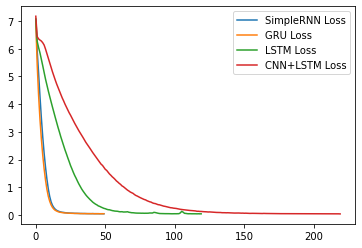

In [ ]:
plt.plot(rnn_r.history['loss'], label="SimpleRNN Loss")
plt.plot(gru_r.history['loss'], label="GRU Loss")
plt.plot(lstm_r.history['loss'], label="LSTM Loss")
plt.plot(cnn_r.history['loss'], label="CNN+LSTM Loss")
plt.legend()

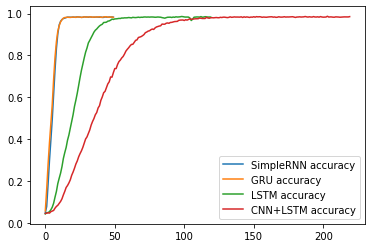

In [ ]:
plt.plot(rnn_r.history['accuracy'], label="SimpleRNN accuracy")
plt.plot(gru_r.history['accuracy'], label="GRU accuracy")
plt.plot(lstm_r.history['accuracy'], label="LSTM accuracy")
plt.plot(cnn_r.history['accuracy'], label="CNN+LSTM accuracy")
plt.legend()

# Generating A Rap

Raps are generated by using a markov model to generate the first three words of a bar.

Those three words are fed into the given model to finish the bar. 

The bar is then rated against the given artist's lyrics with rhyme index, uniquness, and comprehension as the metrics.

We want to generate bars with similar rhyme indicies and comprehension scores as the artist, but we want to ensure the bars are unique. 

In [ ]:
def generate_rap(model, artists_bars, length_of_bar=10, length_of_rap=20, min_score_threshold=-0.2, max_score_threshold=0.2, tries=5):
  artists_avg_readability = calc_readability(artists_bars)
  artists_avg_rhyme_idx = calc_rhyme_density(artists_bars)
  fire_rap = []
  cur_tries = 0
  candidate_bars = []

  while len(fire_rap) < length_of_rap:
    seed_phrase = markov_model.make_sentence(tries=500).split(" ")
    seed_phrase = " ".join(seed_phrase[:3])
    cur_tries += 1
    bar = generate_bar(seed_phrase, model, rand.randrange(4, length_of_bar))
    bar_score = score_bar(bar, artist_lyrics, artists_avg_readability, artists_avg_rhyme_idx) 
    candidate_bars.append((bar_score, bar))

    if bar_score <= max_score_threshold and bar_score >= min_score_threshold:
      fire_rap.append(bar)
      cur_tries = 0
      print("Generated Bar: ", len(fire_rap))

    if cur_tries >= tries:
      lowest_score = np.Infinity
      best_bar = ""
      for bar in candidate_bars:
        if bar[0] < lowest_score:
          best_bar = bar[1]
          candidate_bars = []
      
      print("Generated Bar: ", len(fire_rap))
      fire_rap.append(best_bar)
      cur_tries = 0
      
  print("Generated rap with avg rhyme density: ", calc_rhyme_density(fire_rap), "and avg readability of: ", calc_readability(fire_rap))
  return fire_rap

In [ ]:
def generate_bar(seed_phrase, model, length_of_bar):
  for i in range(length_of_bar):
    seed_tokens = pad_sequences(tokenizer.texts_to_sequences([seed_phrase]), maxlen=29)
    output_p = model.predict(seed_tokens)
    output_word = np.argmax(output_p, axis=1)[0]-1
    seed_phrase += " " + str(list(tokenizer.word_index.items())[output_word][0])
  return seed_phrase

In [ ]:
def compare_bars(input_bar, artists_bars):
  '''
    input_bars are the fire bars our AI generates
    artists_bars are the original bars for the artist

    The lower the score the better! We want unique bars
  '''
  # Converts sentences to matrix of token counts
  avg_dist = 0
  total_counted = 0
  for bar in artists_bars:
    v = CountVectorizer()
    # Vectorize the sentences
    word_vector = v.fit_transform([input_bar, bar])
    # Compute the cosine distance between the sentence vectors
    cos_dist = 1-pdist(word_vector.toarray(), 'cosine')[0]
    if not math.isnan(cos_dist):
      avg_dist += 1-pdist(word_vector.toarray(), 'cosine')[0]
      total_counted += 1
  return avg_dist/total_counted

In [ ]:
''' Rhyme density is calculated by taking the number of rhymed syllables and divide it by total number of syllables'''
def calc_rhyme_density(bars):
  total_syllables = 0
  rhymed_syllables = 0
  for bar in bars:
    for word in bar.split():
      p = pronouncing.phones_for_word(word)
      if len(p) == 0:
        break
      syllables = pronouncing.syllable_count(p[0])
      total_syllables += syllables
      has_rhyme = False
      for rhyme in pronouncing.rhymes(word):
        if has_rhyme:
          break
        for idx, r_bar in enumerate(bars):
          if idx > 4:
            break
          if rhyme in r_bar:
            rhymed_syllables += syllables
            has_rhyme = True
            break
  return rhymed_syllables/total_syllables


In [ ]:
def calc_readability(input_bars):
  avg_readability = 0
  for bar in input_bars:
    avg_readability += textstat.automated_readability_index(bar)
  return avg_readability / len(input_bars)

In [ ]:
def score_bar(input_bar, artists_bars, artists_avg_readability, artists_avg_rhyme_idx):
  gen_readability = textstat.automated_readability_index(input_bar)
  gen_rhyme_idx = calc_rhyme_density(input_bar)
  comp_bars = compare_bars(input_bar, artists_bars)

  # Scores based off readability, rhyme index, and originality. The lower the score the better.
  bar_score = (artists_avg_readability - gen_readability) + (artists_avg_rhyme_idx - gen_rhyme_idx) + comp_bars
  return bar_score

Finally, Generate four different rap songs utilizing the SimpleRNN, GRU, LSTM, and CNN+LSTM architectures.

In [ ]:
seed_sentence = markov_model.make_sentence(tries=100).split(" ")
seed_sentence = " ".join(seed_sentence[:5])

rnn = generate_rap(seed_sentence, rnn_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with SimpleRNN:")
for line in rnn:
  print(line)
print()

gru = generate_rap(seed_sentence, gru_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with GRU:")
for line in gru:
  print(line)
print()

lstm = generate_rap(seed_sentence, lstm_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with LSTM:")
for line in lstm:
  print(line)
print()

cnn = generate_rap(seed_sentence, cnn_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with CNN+LSTM:")
for line in cnn:
  print(line)

Generated Bar:  1
Generated Bar:  2
Generated Bar:  3
Generated Bar:  4
Generated Bar:  5
Generated Bar:  6
Generated Bar:  7
Generated Bar:  8
Generated Bar:  9
Generated Bar:  10
Generated Bar:  11
Generated Bar:  12
Generated Bar:  13
Generated Bar:  14
Generated Bar:  15
Generated Bar:  16
Generated Bar:  17
Generated Bar:  18
Generated Bar:  19
Generated Bar:  20
Generated rap with avg rhyme density:  0.5030674846625767 and avg readability of:  2.0599999999999996
Rap Generated with SimpleRNN:
Now you're throwing me baby know it know
Look I gotta started with you hook drake
I swear it happened no tellin' yeah yeah
Turn my birthday man low changed you
I see em right now hook drake again things alone
That new s*** teams rufio copy rose more
I love the picture you know hook drake back back
Yeah, but shout yeah yeah yeah yeah yeah
Yeah I'm leaving, one time back dog life
Woah, woah, heard woah yeah oh yeah yeah
I got money away blow now tellin' yeah yeah yeah
You know what know though 